In [309]:
import numpy as np
import pandas as pd
from scipy.special import gamma
from scipy.linalg import det, inv
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
import os
from scipy.stats import zscore
from sklearn.cluster import KMeans
import random
from scipy.io import savemat

In [310]:
feelings = ['MetaAwareness','Presence','PhysicalEffort','MentalEffort','Boredom', 'Receptivity', 'EmotionalIntensity', 'Clarity', 'Release', 'Bliss', 'Embodiment', 'Insightfulness', 'Anxiety', 'SpiritualExperience']
csv_file_path = "C:/Users/hugma/diss/NDT_all_12thDec_uncleaned.csv"

In [311]:
def trainHMM(data, numStates, means, covariances, transProb, nu):
    maxIter = 100
    tol = 1e-4
    num_emissions = data.shape[1]
    for iter in range(0,maxIter):
        gamma, xi = eStep(data, numStates, transProb, means, covariances, nu)
        transProb = updateTransitionProbabilities(xi)
        [means, covariances, nu] = updateEmissionParameters(data, gamma, numStates,make_positive_definite, estimate_nu)

    return transProb, means, covariances, nu

In [312]:
def visualizeClustersAndTransitions(data, clusters, labels):
    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=2)
    score = pca.fit_transform(data)

    # Use the first two principal components for visualization
    pc1 = score[:, 0]
    pc2 = score[:, 1]

    plt.figure()
    plt.title('Clusters and Transitions (PCA)')
    
    # Define colors for clusters
    colors = plt.cm.get_cmap('tab10', np.max(clusters) + 1)
    
    # Plot data points with cluster colors
    for i in range(1, np.max(clusters) + 1):
        cluster_idx = clusters == i
        plt.scatter(pc1[cluster_idx], pc2[cluster_idx], s=10, color=colors(i), label=f'Cluster {i}', alpha=0.6)
    
    # Plot transition lines
    for i in range(1, len(labels)):
        if isinstance(labels[i], str) and 'Transition' in labels[i]:
            plt.plot([pc1[i-1], pc1[i]], [pc2[i-1], pc2[i]], 'k--', linewidth=1.5)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    # Create a legend for the clusters
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors(i), markersize=6) for i in range(1, np.max(clusters) + 1)]
    plt.legend(handles=handles, labels=[f'Cluster {i}' for i in range(1, np.max(clusters) + 1)])
    
    plt.show()

In [313]:
def eStep(data, numStates, transProb, means, covariances, nu):
    numData, numFeatures = data.shape

    # Validate the shape of covariances
    print(f"Expected covariance shape: {(numFeatures, numFeatures, numStates)}")
    print(f"Actual covariance shape: {covariances.shape}")

    # Print covariance shapes at each step
    for j in range(numStates):
        print(f"Covariance matrix shape for state {j}: {covariances[j, :, :].shape}")

    alpha = np.zeros((numData, numStates))
    beta = np.zeros((numData, numStates))
    gamma = np.zeros((numData, numStates))
    xi = np.zeros((numStates, numStates, numData - 1))

    # Compute alpha
    for t in range(numData):
        for j in range(numStates):
            try:
                

                if t == 0:
                    alpha[t, j] = mvtpdf(data[t, :], means[j, :], covariances[j, :, :], nu[j]) * (1 / numStates)
                else:
                    alpha[t, j] = mvtpdf(data[t, :], means[j, :], covariances[j, :, :], nu[j]) * np.sum(alpha[t - 1, :] * transProb[:, j])
            except Exception as e:
                print(f"Error computing alpha at t={t}, state={j}: {e}")
        alpha[t, :] = alpha[t, :] / np.sum(alpha[t, :]) if np.sum(alpha[t, :]) > 0 else alpha[t, :]

    # Compute beta
    beta[-1, :] = 1
    for t in range(numData - 2, -1, -1):
        for i in range(numStates):
            try:
                beta[t, i] = np.sum(
                    beta[t + 1, :] * transProb[i, :] * np.array([mvtpdf(data[t + 1, :], means[j, :], covariances[j, :, :], nu[j]) for j in range(numStates)])
                )
            except Exception as e:
                print(f"Error computing beta at t={t}, state={i}: {e}")
        beta[t, :] = beta[t, :] / np.sum(beta[t, :]) if np.sum(beta[t, :]) > 0 else beta[t, :]

    # Compute gamma
    for t in range(numData):
        gamma[t, :] = alpha[t, :] * beta[t, :]
        gamma[t, :] = gamma[t, :] / np.sum(gamma[t, :]) if np.sum(gamma[t, :]) > 0 else gamma[t, :]

    # Compute xi
    for t in range(numData - 1):
        for i in range(numStates):
            for j in range(numStates):
                try:
                    xi[i, j, t] = (alpha[t, i] * transProb[i, j] *
                                   mvtpdf(data[t + 1, :], means[j, :], covariances[j, :, :], nu[j]) * beta[t + 1, j])
                except Exception as e:
                    print(f"Error computing xi at t={t}, state_i={i}, state_j={j}: {e}")
        xi[:, :, t] = xi[:, :, t] / np.sum(xi[:, :, t]) if np.sum(xi[:, :, t]) > 0 else xi[:, :, t]

    return gamma, xi


In [314]:
def mvtpdf(x, mu, Sigma, nu):
    """
    Compute the multivariate Student's t-distribution PDF.

    Parameters:
    - x: Data point (array-like), should be of shape (d,)
    - mu: Mean vector (array-like), should be of shape (d,)
    - Sigma: Covariance matrix (array-like), should be of shape (d, d)
    - nu: Degrees of freedom

    Returns:
    - p: Probability density function value
    """
    d = len(mu)
    x_mu = x - mu

    try:
        Sigma_inv = inv(Sigma)
        det_Sigma = det(Sigma)
        mahalanobis_dist = np.dot(x_mu, np.dot(Sigma_inv, x_mu))
        
        normalization_const = (gamma((d + nu) / 2) /
                               (gamma(nu / 2) * (np.pi**(d / 2)) * (det_Sigma**0.5) *
                                (1 + mahalanobis_dist / nu)**((d + nu) / 2)))
        
        return normalization_const
    
    except np.linalg.LinAlgError:
        # Handle singular matrix or other errors in inversion/determinant calculation
        return 0.0

In [315]:
def updateTransitionProbabilities(xi):
    transProb = np.sum(xi,axis=2)
    transProb = transProb / np.sum(transProb, axis=1)
    return transProb

In [316]:
def updateEmissionParameters(data, gamma, numStates, makePositiveDefinite, estimateNu):
    numData, numEmissions = data.shape
    means = np.zeros((numStates, numEmissions))
    covariances = np.zeros((numStates, numEmissions, numEmissions))
    nu = np.zeros(numStates)
    
    for j in range(numStates):
        gamma_j = gamma[:, j]
        sum_gamma_j = np.sum(gamma_j)
        
        # Update means
        means[j, :] = np.sum(data * gamma_j[:, np.newaxis], axis=0) / sum_gamma_j
        
        # Update covariances
        S = np.zeros((numEmissions, numEmissions))
        for t in range(numData):
            diff = data[t, :] - means[j, :]
            S += gamma_j[t] * np.outer(diff, diff)
        covariances[j, :, :] = S / sum_gamma_j
        
        # Ensure covariance matrix is positive definite
        covariances[j, :, :] = makePositiveDefinite(covariances[j, :, :])
        
        # Update nu
        nu[j] = estimateNu(gamma_j, data, means[j, :], covariances[j, :, :])
    
    return means, covariances, nu

In [317]:
def make_positive_definite(cov_matrix):
    # Add a small value to the diagonal to ensure positive definiteness
    min_eigenvalue = 1e-6
    cov_matrix = np.array(cov_matrix)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    eigenvalues[eigenvalues < min_eigenvalue] = min_eigenvalue
    cov_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
    return cov_matrix

In [318]:
def decodeHMM(data, transProb, means, covariances, nu):
    """
    Decode a Hidden Markov Model using the Viterbi algorithm.

    Parameters:
    data (array): The observed data (numData x numFeatures)
    transProb (array): State transition probability matrix (numStates x numStates)
    means (array): Mean vectors for each state (numStates x numFeatures)
    covariances (array): Covariance matrices for each state (numStates x numFeatures x numFeatures)
    nu (array): Degrees of freedom for the t-distribution for each state (numStates,)

    Returns:
    stateSeq (array): The most probable sequence of states
    logProb (float): The log-probability of the most probable state sequence
    """
    numData = data.shape[0]
    numStates = transProb.shape[0]
    
    delta = np.zeros((numData, numStates))
    psi = np.zeros((numData, numStates), dtype=int)
    
    # Initialization step
    for j in range(numStates):
        covMat = covariances[j, :, :] if covariances.ndim == 3 else covariances[j, :]
        delta[0, j] = mvtpdf(data[0, :], means[j, :], covMat, nu[j]) * (1 / numStates)
    
    delta[0, :] /= np.sum(delta[0, :])  # Normalize

    # Recursion step
    for t in range(1, numData):
        for j in range(numStates):
            max_val, max_idx = max((delta[t-1, i] * transProb[i, j], i) for i in range(numStates))
            covMat = covariances[j, :, :] if covariances.ndim == 3 else covariances[j, :]
            delta[t, j] = max_val * mvtpdf(data[t, :], means[j, :], covMat, nu[j])
            psi[t, j] = max_idx
        
        delta[t, :] /= np.sum(delta[t, :])  # Normalize

    # Backtracking step
    stateSeq = np.zeros(numData, dtype=int)
    stateSeq[-1] = np.argmax(delta[-1, :])
    
    for t in range(numData-2, -1, -1):
        stateSeq[t] = psi[t+1, stateSeq[t+1]]
    
    # Log-probability of the most probable state sequence
    logProb = np.sum(np.log(np.max(delta, axis=1)))
    
    return stateSeq, logProb

In [319]:
def estimate_nu(gamma, data, mean, covariance):
    nu = 5  # Initial guess
    tol = 1e-3
    maxIter = 100
    for _ in range(maxIter):
        old_nu = nu
        # Update nu based on some iterative method, e.g., Newton-Raphson
        # For simplicity, we keep it constant here
        if np.abs(nu - old_nu) < tol:
            break
    return nu

In [320]:
def visualizeSession(resultsTable, startRow, endRow):
    # Extract the relevant segment from the results table
    segment = resultsTable.iloc[startRow:endRow, :]

    # Define the state colors
    stateColors = plt.cm.get_cmap('tab10', int(segment['State'].max() + 1))

    # Plot the data for each dimension
    plt.figure()
    plt.title(f'EEG Data Visualization from Row {startRow} to {endRow}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude (offset for each dimension)')
   

    numDimensions = segment['TETData'].iloc[0].size
    offset = 5

    for i in range(numDimensions):
        plt.plot(segment['TETData'].apply(lambda x: x[i]) + offset * i)

    # Add shaded areas for each state
    max_value = max(segment['TETData'].apply(np.max)) + 2 * numDimensions
    for i in range(1, int(segment['State'].max()) + 1):
        idx = segment['State'] == i
        if idx.any():
            plt.fill_between(
                np.where(idx)[0], 
                0, 
                max_value, 
                color=stateColors(i / (segment['State'].max() + 1)), 
                alpha=0.3
            )

    # Add transition windows
    for i, transWindow in enumerate(segment['TransitionalWindow']):
        if transWindow:
            transWindow = list(map(int, transWindow.replace('Start: ', '').replace('End: ', '').split(',')))
            x = np.arange(transWindow[0], transWindow[1] + 1)
            if len(x) > 0 and x[-1] <= endRow:
                plt.plot(x, [max_value] * len(x), 'k-', linewidth=2)

    plt.show()

In [321]:
def load_tet_data(csv_file_path, feelings):
    # Load the entire CSV file into a DataFrame
    data = pd.read_csv(csv_file_path)

    # Check if the necessary columns exist in the data
    if not set(['Session', 'Week', 'Subject']).issubset(data.columns):
        raise ValueError('CSV file is missing one or more of the required columns: Session, Week, Subject.')

    if not set(feelings).issubset(data.columns):
        raise ValueError('CSV file is missing one or more of the required "feelings" columns.')

    # Extract TET data based on the 'feelings' array
    all_tet_data = data[feelings]

    # Extract metadata columns
    session_ids = data['Session'].tolist()
    weeks = data['Week'].tolist()
    subjects = data['Subject'].tolist()

    # Create unique session identifiers based on the combination of Session, Week, and Subject
    unique_session_ids = [f'{s}_Week{w}_Subject{sbj}' for s, w, sbj in zip(session_ids, weeks, subjects)]

    return all_tet_data, session_ids, weeks, subjects, unique_session_ids

In [322]:
def forwardBackward(data, transProb, means, covariances, nu):
    """
    Forward-backward algorithm for Hidden Markov Models.

    Parameters:
    data (array): The observed data (numData x numFeatures)
    transProb (array): State transition probability matrix (numStates x numStates)
    means (array): Mean vectors for each state (numStates x numFeatures)
    covariances (array): Covariance matrices for each state (numStates x numFeatures x numFeatures)
    nu (array): Degrees of freedom for the t-distribution for each state (numStates,)

    Returns:
    alpha (array): Forward probabilities
    beta (array): Backward probabilities
    gamma (array): State probabilities
    logLik (float): Log-likelihood of the data
    """
    numData = data.shape[0]
    numStates = transProb.shape[0]
    
    alpha = np.zeros((numData, numStates))
    beta = np.zeros((numData, numStates))
    gamma = np.zeros((numData, numStates))
    
    # Forward pass
    for t in range(numData):
        for j in range(numStates):
            covMat = covariances[j, :, :] if covariances.ndim == 3 else covariances[j, :]
            if t == 0:
                alpha[t, j] = mvtpdf(data[t, :], means[j, :], covMat, nu[j]) * (1 / numStates)
            else:
                alpha[t, j] = mvtpdf(data[t, :], means[j, :], covMat, nu[j]) * np.sum(alpha[t-1, :] * transProb[:, j])
        
        alpha[t, :] /= np.sum(alpha[t, :])  # Normalize

    # Backward pass
    beta[-1, :] = 1  # Initialize beta at the last time step

    for t in range(numData-2, -1, -1):
        for i in range(numStates):
            beta[t, i] = np.sum(beta[t+1, :] * transProb[i, :] * 
                                np.array([mvtpdf(data[t+1, :], means[j, :], 
                                covariances[j, :, :] if covariances.ndim == 3 else covariances[j, :], nu[j]) 
                                for j in range(numStates)]))
        
        beta[t, :] /= np.sum(beta[t, :])  # Normalize

    # Compute gamma
    for t in range(numData):
        gamma[t, :] = alpha[t, :] * beta[t, :]
        gamma[t, :] /= np.sum(gamma[t, :])  # Normalize

    # Compute log-likelihood
    logLik = np.sum(np.log(np.sum(alpha, axis=1)))
    
    return alpha, beta, gamma, logLik

In [323]:
allTETData, session_ids, weeks, subjects, unique_session_ids = load_tet_data(csv_file_path, feelings)

Repetition 1 of 2
Transition probabilities shape: (4, 4)
Emission means shape: (4, 14)
Emission covariances shape: (4, 14, 14)
Degrees of freedom shape: (4,)
Expected covariance shape: (14, 14, 4)
Actual covariance shape: (4, 14, 14)
Covariance matrix shape for state 0: (14, 14)
Covariance matrix shape for state 1: (14, 14)
Covariance matrix shape for state 2: (14, 14)
Covariance matrix shape for state 3: (14, 14)
Expected covariance shape: (14, 14, 4)
Actual covariance shape: (4, 14, 14)
Covariance matrix shape for state 0: (14, 14)
Covariance matrix shape for state 1: (14, 14)
Covariance matrix shape for state 2: (14, 14)
Covariance matrix shape for state 3: (14, 14)
Expected covariance shape: (14, 14, 4)
Actual covariance shape: (4, 14, 14)
Covariance matrix shape for state 0: (14, 14)
Covariance matrix shape for state 1: (14, 14)
Covariance matrix shape for state 2: (14, 14)
Covariance matrix shape for state 3: (14, 14)
Expected covariance shape: (14, 14, 4)
Actual covariance shape

C:\Users\hugma\AppData\Local\Temp\ipykernel_29904\2679772251.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', np.max(clusters) + 1)


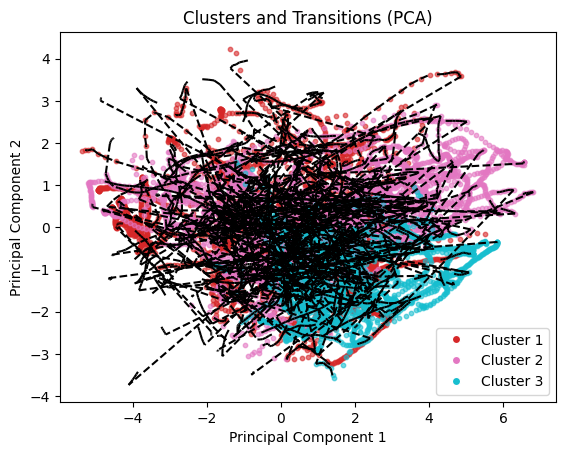

C:\Users\hugma\AppData\Local\Temp\ipykernel_29904\3005286074.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  stateColors = plt.cm.get_cmap('tab10', int(segment['State'].max() + 1))


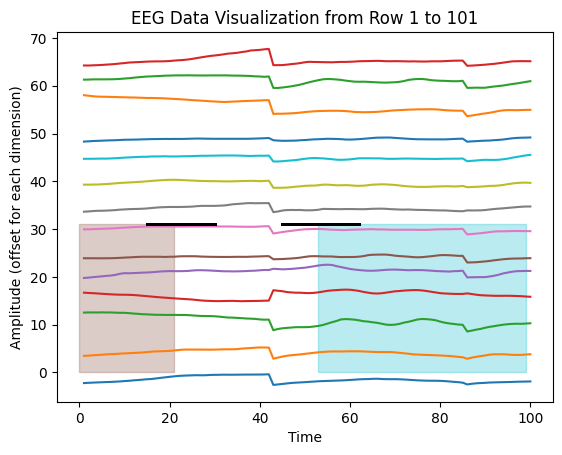

In [324]:

allTETData = zscore(allTETData).values

# Set the random seed for reproducibility
np.random.seed(12345)
random.seed(12345)

# Set the number of clusters
optimal_k = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, n_init=1000, random_state=12345)
idx = kmeans.fit_predict(allTETData)
C = kmeans.cluster_centers_

# Initialize storage for averaging
numRepetitions = 2
allTransProbs = np.zeros((optimal_k, optimal_k, numRepetitions))
allEmissionMeans = np.zeros((optimal_k, allTETData.shape[1], numRepetitions))
allEmissionCovs = np.zeros((optimal_k, allTETData.shape[1], allTETData.shape[1], numRepetitions))
allFs = np.zeros((allTETData.shape[0], optimal_k, numRepetitions))
allStateSeqs = np.zeros((allTETData.shape[0], numRepetitions))

# Folder to save repetitions
saveFolder = '/Users/hugma/diss/data_hmm'
if not os.path.exists(saveFolder):
    os.makedirs(saveFolder)

# Repeat the HMM process
for rep in range(numRepetitions):
    print(f'Repetition {rep + 1} of {numRepetitions}')

    # Set a fixed random seed before initializing random parameters
    np.random.seed(12345 + rep)
    random.seed(12345 + rep)

    numStates = optimal_k
    numEmissions = allTETData.shape[1]

    # Initialize transition probabilities
    transProb = np.random.rand(numStates, numStates)
    transProb /= transProb.sum(axis=1)[:, np.newaxis]  # Normalize to make it stochastic

    # Initialize emission means
    emissionMean = np.random.rand(numStates, numEmissions)

    
    emissionCov = np.stack([np.eye(numEmissions)] * numStates)

    # Initial guess for degrees of freedom
    nu = np.full(numStates, 5)

    # Debugging: Print shapes to ensure they match expectations
    print(f"Transition probabilities shape: {transProb.shape}")
    print(f"Emission means shape: {emissionMean.shape}")
    print(f"Emission covariances shape: {emissionCov.shape}")
    print(f"Degrees of freedom shape: {nu.shape}")

    # Train HMM using Baum-Welch algorithm (custom implementation)
    transProb, emissionMean, emissionCov, nu = trainHMM(allTETData, numStates, emissionMean, emissionCov, transProb, nu)

    # Decode the sequence using the Viterbi algorithm
    stateSeq, logProb = decodeHMM(allTETData[:, :14], transProb, emissionMean, emissionCov, nu)

    # Calculate state probabilities using the custom forward-backward algorithm
    alpha, beta, fs, logLik = forwardBackward(allTETData[:, :14], transProb, emissionMean, emissionCov, nu)

    # Store results for averaging
    allTransProbs[:, :, rep] = transProb
    allEmissionMeans[:, :, rep] = emissionMean
    allEmissionCovs[:, :, :, rep] = emissionCov
    allFs[:, :, rep] = fs
    allStateSeqs[:, rep] = stateSeq

    # Save the results of this repetition
    saveFile = os.path.join(saveFolder, f'repetition_{rep + 1}.mat')
    savemat(saveFile, {
        'transProb': transProb,
        'emissionMean': emissionMean,
        'emissionCov': emissionCov,
        'nu': nu,
        'stateSeq': stateSeq,
        'fs': fs,
        'logProb': logProb,
        'logLik': logLik
    })

# Average the results across repetitions
avgTransProb = np.mean(allTransProbs, axis=2)
avgEmissionMeans = np.mean(allEmissionMeans, axis=2)
avgEmissionCovs = np.mean(allEmissionCovs, axis=3)
avgFs = np.mean(allFs, axis=2)
avgStateSeq = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=allStateSeqs)

# Set minimum state duration
minStateLength = 10

# Calculate the distribution of changes in state probabilities
changes = np.abs(np.diff(avgFs, axis=0))
meanChange = np.mean(changes)
stdChange = np.std(changes)

# Print mean and standard deviation of changes
print(f'Mean of changes: {meanChange}')
print(f'Standard deviation of changes: {stdChange}')

# Define an even more lenient threshold
threshold = meanChange + 0.05 * stdChange
print(f'Chosen threshold based on data distribution: {threshold}')

# Initialize labels and transition windows
labels = [''] * allTETData.shape[0]
transitionalWindows = [''] * allTETData.shape[0]

# Define the initial buffer size increment for checking purposes
initialBufferSize = 5  # Increase initial buffer size

# Identify transitions and label them dynamically
sessionLength = 101

for i in range(1, len(avgStateSeq)):
    if avgStateSeq[i] != avgStateSeq[i-1] and (i % sessionLength) != 1:
        # Check the duration of the previous state
        prevState = avgStateSeq[i-1]
        prevStateLength = 1
        for j in range(i-2, -1, -1):
            if avgStateSeq[j] == prevState:
                prevStateLength += 1
            else:
                break

        # Check the duration of the new state
        newState = avgStateSeq[i]
        newStateLength = 1
        for j in range(i+1, len(avgStateSeq)):
            if avgStateSeq[j] == newState:
                newStateLength += 1
            else:
                break

        # Skip labeling if either the previous or the new state is shorter than minStateLength
        if prevStateLength < minStateLength or newStateLength < minStateLength:
            continue

        # Explicitly skip transitions if the new state has a duration of 15 rows or fewer
        if newStateLength <= 10:
            continue

        # Check if there is a short state between two valid states and skip it
        if newStateLength < minStateLength and prevStateLength >= minStateLength and newStateLength >= minStateLength:
            continue

        startIdx = i

        # Move backwards to find the start of the transition
        while startIdx > 0 and np.abs(avgFs[startIdx, newState] - avgFs[startIdx-1, newState]) > threshold:
            startIdx -= 1

        endIdx = i

        # Move forwards to find the end of the transition
        while endIdx < len(avgStateSeq) - 1 and np.abs(avgFs[endIdx, newState] - avgFs[endIdx+1, newState]) > threshold:
            endIdx += 1

        # Dynamically adjust the buffer size for the start of the transition
        dynamicBufferSizeStart = initialBufferSize
        while startIdx - dynamicBufferSizeStart > 0 and np.abs(avgFs[max(0, startIdx - dynamicBufferSizeStart), newState] - avgFs[max(0, startIdx - dynamicBufferSizeStart + 1), newState]) > threshold / 2:
            dynamicBufferSizeStart += 1

        # Dynamically adjust the buffer size for the end of the transition
        dynamicBufferSizeEnd = initialBufferSize
        while endIdx + dynamicBufferSizeEnd < len(avgStateSeq) and np.abs(avgFs[min(len(avgStateSeq)-1, endIdx + dynamicBufferSizeEnd), newState] - avgFs[min(len(avgStateSeq)-1, endIdx + dynamicBufferSizeEnd - 1), newState]) > threshold / 2:
            dynamicBufferSizeEnd += 1

        # Update the start and end indices with dynamic buffers
        startIdx = max(0, startIdx - dynamicBufferSizeStart)
        endIdx = min(len(avgStateSeq)-1, endIdx + dynamicBufferSizeEnd)

        # Additional check to avoid counting transitions between the same states
        if avgStateSeq[startIdx] == avgStateSeq[endIdx]:
            continue  # Skip this transition if the start and end states are the same

        # Label the transition
        for j in range(startIdx, endIdx + 1):
            labels[j] = f'Transition from S{avgStateSeq[startIdx]} to S{avgStateSeq[endIdx]}'
            transitionalWindows[j] = f'Start: {startIdx}, End: {endIdx}'

# Count the number of transitions
numTransitions = sum(1 for label in labels if label)
print(f'Number of transitions labeled: {numTransitions}')

resultsTable = pd.DataFrame({
    'TETData': list(allTETData),
    'State': avgStateSeq,
    'SessionID': session_ids,
    'Label': labels,
    'TransitionalWindow': transitionalWindows,
    'Week': weeks,
    'SessionID': unique_session_ids,
    'Subject' : subjects
})

print(resultsTable)

# Display the transition matrix
print('Averaged Transition Matrix:')
print(avgTransProb)

# Visualize clusters and transitions using PCA for dimensionality reduction
visualizeClustersAndTransitions(allTETData, avgStateSeq, labels)

# Visualize the first session (rows 1 to 101)
visualizeSession(resultsTable, 1, 101)

